In [1]:
import gc
from itertools import combinations
import pathlib
from typing import Any, Dict, List
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary   
import yaml


gc.enable()
pd.set_option('display.max_columns', 200)
warnings.simplefilter('ignore')

In [2]:
inputs_dir_path = pathlib.Path('../inputs')
outputs_dir_path = pathlib.Path('../outputs')
if not outputs_dir_path.is_dir():
    outputs_dir_path.mkdir()

train_df = pd.read_csv(inputs_dir_path. joinpath('train.csv'))
train_df.drop(columns=['row_id', 'time_id'], inplace=True)
display(train_df)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184


In [3]:
cast_dtypes = {
    'stock_id': np.int16,
    'date_id': np.int16,
    'seconds_in_bucket': np.int16,
    'imbalance_size': np.float32,
    'imbalance_buy_sell_flag': np.int16,
    'reference_price': np.float32,
    'matched_size': np.float32,
    'far_price': np.float32,
    'near_price': np.float32,
    'bid_price': np.float32,
    'bid_size': np.float32,
    'ask_price': np.float32,
    'ask_size': np.float32,
    'wap': np.float32,
    'target': np.float32
}

display(train_df.dtypes)
train_df = train_df.astype(cast_dtypes)
display(train_df)

stock_id                     int64
date_id                      int64
seconds_in_bucket            int64
imbalance_size             float64
imbalance_buy_sell_flag      int64
reference_price            float64
matched_size               float64
far_price                  float64
near_price                 float64
bid_price                  float64
bid_size                   float64
ask_price                  float64
ask_size                   float64
wap                        float64
target                     float64
dtype: object

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,0,0,3.180603e+06,1,0.999812,13380277.00,NaN,NaN,0.999812,60651.500000,1.000026,8493.030273,1.000000,-3.029704
1,1,0,0,1.666039e+05,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.040039,1.000660,20605.089844,1.000000,-5.519986
2,2,0,0,3.028799e+05,-1,0.999561,1819368.00,NaN,NaN,0.999403,37956.000000,1.000298,18995.000000,1.000000,-8.389950
3,3,0,0,1.191768e+07,-1,1.000171,18389746.00,NaN,NaN,0.999999,2324.899902,1.000214,479032.406250,1.000000,-4.010201
4,4,0,0,4.475500e+05,-1,0.999532,17860614.00,NaN,NaN,0.999394,16485.539062,1.000016,434.100006,1.000000,-7.349849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2.440723e+06,-1,1.000317,28280362.00,0.999734,0.999734,1.000317,32257.039062,1.000434,319862.406250,1.000328,2.310276
5237976,196,480,540,3.495105e+05,-1,1.000643,9187699.00,1.000129,1.000386,1.000643,205108.406250,1.000900,93393.070312,1.000819,-8.220077
5237977,197,480,540,0.000000e+00,0,0.995789,12725436.00,0.995789,0.995789,0.995789,16790.660156,0.995883,180038.312500,0.995797,1.169443
5237978,198,480,540,1.000899e+06,1,0.999210,94773272.00,0.999210,0.999210,0.998970,125631.718750,0.999210,669893.000000,0.999008,-1.540184


In [4]:
train_df = train_df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).sort_index().unstack(level=0)
train_df.columns = [col[0] + '_' + str(col[1]) for col in train_df.columns]
train_df.reset_index(drop=False, inplace=True)
display(train_df)

,date_id,seconds_in_bucket,imbalance_size_0,imbalance_size_1,imbalance_size_2,imbalance_size_3,imbalance_size_4,imbalance_size_5,imbalance_size_6,imbalance_size_7,imbalance_size_8,imbalance_size_9,imbalance_size_10,imbalance_size_11,imbalance_size_12,imbalance_size_13,imbalance_size_14,imbalance_size_15,imbalance_size_16,imbalance_size_17,imbalance_size_18,imbalance_size_19,imbalance_size_20,imbalance_size_21,imbalance_size_22,imbalance_size_23,imbalance_size_24,imbalance_size_25,imbalance_size_26,imbalance_size_27,imbalance_size_28,imbalance_size_29,imbalance_size_30,imbalance_size_31,imbalance_size_32,imbalance_size_33,imbalance_size_34,imbalance_size_35,imbalance_size_36,imbalance_size_37,imbalance_size_38,imbalance_size_39,imbalance_size_40,imbalance_size_41,imbalance_size_42,imbalance_size_43,imbalance_size_44,imbalance_size_45,imbalance_size_46,imbalance_size_47,imbalance_size_48,imbalance_size_49,imbalance_size_50,imbalance_size_51,imbalance_size_52,imbalance_size_53,imbalance_size_54,imbalance_size_55,imbalance_size_56,imbalance_size_57,imbalance_size_58,imbalance_size_59,imbalance_size_60,imbalance_size_61,imbalance_size_62,imbalance_size_63,imbalance_size_64,imbalance_size_65,imbalance_size_66,imbalance_size_67,imbalance_size_68,imbalance_size_69,imbalance_size_70,imbalance_size_71,imbalance_size_72,imbalance_size_73,imbalance_size_74,imbalance_size_75,imbalance_size_76,imbalance_size_77,imbalance_size_78,imbalance_size_79,imbalance_size_80,imbalance_size_81,imbalance_size_82,imbalance_size_83,imbalance_size_84,imbalance_size_85,imbalance_size_86,imbalance_size_87,imbalance_size_88,imbalance_size_89,imbalance_size_90,imbalance_size_91,imbalance_size_92,imbalance_size_93,imbalance_size_94,imbalance_size_95,imbalance_size_96,imbalance_size_97,...,target_100,target_101,target_102,target_103,target_104,target_105,target_106,target_107,target_108,target_109,target_110,target_111,target_112,target_113,target_114,target_115,target_116,target_117,target_118,target_119,target_120,target_121,target_122,target_123,target_124,target_125,target_126,target_127,target_128,target_129,target_130,target_131,target_132,target_133,target_134,target_135,target_136,target_137,target_138,target_139,target_140,target_141,target_142,target_143,target_144,target_145,target_146,target_147,target_148,target_149,target_150,target_151,target_152,target_153,target_154,target_155,target_156,target_157,target_158,target_159,target_160,target_161,target_162,target_163,target_164,target_165,target_166,target_167,target_168,target_169,target_170,target_171,target_172,target_173,target_174,target_175,target_176,target_177,target_178,target_179,target_180,target_181,target_182,target_183,target_184,target_185,target_186,target_187,target_188,target_189,target_190,target_191,target_192,target_193,target_194,target_195,target_196,target_197,target_198,target_199
0,0,0,3.180603e+06,166603.906250,302879.875000,11917682.00,4.475500e+05,0.000,969969.3750,9412959.00,2.394876e+06,3039700.75,10482752.00,1.506120e+06,1.173994e+07,5749286.000,8899495.0,4469771.00,4.724994e+05,1.241136e+07,516904.03125,0.0,3301736.000,1.015154e+06,5053388.0,7.328708e+05,1757293.625,6.555274e+05,1.919890e+05,1.582624e+06,2840408.00,19144428.00,1.064577e+06,744025.187500,3099124.750,1.558262e+06,1.382540e+07,0.0,1.255662e+06,0.000000,8.940184e+06,0.000,3338208.50,12135166.0,0.00000,721591.2500,2283895.75,38373004.0,0.000000e+00,556838.75000,1.226107e+06,730224.25000,6414367.500,0.000000,1.589229e+06,8426806.00,9.572278e+06,2018102.000,2088948.375,3621361.00,7666106.50,848718.8125,0.00,315065.34375,1.399587e+06,81977.507812,3903664.750,3566816.75,0.00000,7227878.50,5.053995e+05,NaN,0.000000,92823248.0,5215740.000,3352781.75,5.985704e+05,2241328.500,0.000000,1.326540e+07,NaN,NaN,152362.218750,1.837981e+07,0.0000,46313132.00,57964196.00,1.637299e+06,208826.015625,4.038317e+05,3653746.50,0.000,638884.562500,9.686321e+06,0.000000,104769.601562,231633.234375,2.804265e+07,2.634452e+06,0.0000

In [5]:
train_df.set_index(['date_id', 'seconds_in_bucket'], inplace=True)

targets = [f'target_{i}' for i in range(200)]
train_targets = train_df[targets]
train_features = train_df.drop(columns=targets)

train_targets = train_targets.reset_index().fillna(0).set_index(['date_id', 'seconds_in_bucket'])
train_features = train_features.reset_index().fillna(train_df.mean()).set_index(['date_id', 'seconds_in_bucket'])

display(train_targets)
display(train_features)

target_0   target_1  target_2  target_3  target_4  \
date_id seconds_in_bucket                                                      
0       0                 -3.029704  -5.519986 -8.389950 -4.010201 -7.349849   
        10                 0.389814  -1.620054 -7.460117 -1.040101 -6.719828   
        20                 4.220009  -6.459951 -6.380081 -2.030134 -0.690222   
        30                 5.450249  -5.149841 -5.819798  1.130104 -2.589822   
        40                 3.169775  -6.750226 -0.280142 -2.350211 -4.900098   
...                             ...        ...       ...       ...       ...   
480     500                3.999472   2.850294 -4.450083  1.720190  1.939535   
        510                3.190041   3.169775 -5.559921  4.669428  2.139807   
        520               -0.169873   5.689859 -5.310178  5.639791  1.660585   
        530                3.110170  10.650158 -5.239844  5.229712  0.300407   
        540                0.760555  15.859604 -1.549721  3.160238  1.009703   

                           target_5  target_6   target_7  target_8  target_9  \
date_id seconds_in_bucket                                                      
0       0                  6.779432 -2.499819  -1.959801 -5.970001  7.970333   
        10                 7.710457 -4.280210  -8.010268 -0.780225 -0.640154   
        20                 1.009703  2.930164 -12.069941 -4.119873 -3.250241   
        30                -3.089905  0.560284  -6.909966 -1.090169 -6.759763   
        40                -2.070069  2.199411  -1.209974 -3.100038 -8.199811   
...                             ...       ...        ...       ...       ...   
480     500               -4.569888 -0.630021  -1.729727 -0.680089  3.540516   
        510                1.679659 -0.360012  -3.240108  2.609491  1.679659   
        520                2.110004 -1.000166  -4.529953  5.409718  0.350475   
        530               -2.030134 -1.180172  -1.310110  3.240108  0.220537   
        540                2.340078  1.410246  -1.260042  3.679991 -1.609921   

                           target_10  target_11  target_12  target_13  \
date_id seconds_in_bucket                                               
0       0                   5.350113   2.559423   8.399487 -10.750294   
        10                  4.869699   5.400181   4.990101  -4.529953   
        20                  2.260208   1.519918   9.189844  -5.189776   
        30                  3.859997 -13.610125   8.020401  -5.540252   
        40                  5.320311 -21.839737   7.699728  -4.040003   
...                              ...        ...        ...        ...   
480     500                -1.950264   3.340244  -0.280142  -1.220107   
        510                -6.750226  -3.709793  -0.389814  -0.140071   
        520                -7.669926  -2.610087  -2.589822   0.629425   
        530                -9.829998  -6.570220  -3.139973   3.010035   
        540                -0.230074  -1.469851  -0.110269   1.029968   

                           target_14  target_15  target_16  target_17  \
date_id seconds_in_bucket                                               
0       0                   2.319813   1.720190  -8.170009  -3.589988   
        10                 -1.170039   1.280308   4.459620 -13.880134   
        20                  1.469851  -1.360178  -2.589822 -16.229748   
        30                 -0.770092  -2.779961  -0.839829 -11.889935   
        40                 -1.389980  -1.059771   7.289648 -15.770197   
...                              ...        ...        ...        ...   
480     500                -0.510216   0.059605  -1.379848   2.239943   
        510                 2.870560  -2.380013  -0.450015   0.519753   
        520                 2.260208  -0.650287  -2.359748   3.570318   
        530                -3.219843  -2.660155  -1.130104   5.029440   
        540                -2.779961   1.120567  -3.349781  -2.920032   

                           target_18  target_

imbalance_size_0  imbalance_size_1  \
date_id seconds_in_bucket                                       
0       0                      3.180603e+06     166603.906250   
        10                     1.299773e+06     165923.203125   
        20                     1.299773e+06     165923.203125   
        30                     1.299773e+06     165923.203125   
        40                     1.218204e+06     162349.468750   
...                                     ...               ...   
480     500                    0.000000e+00      88468.406250   
        510                    0.000000e+00     310778.500000   
        520                    4.755137e+05     310778.500000   
        530                    4.755137e+05     310778.500000   
        540                    4.755137e+05      43854.511719   

                           imbalance_size_2  imbalance_size_3  \
date_id seconds_in_bucket                                       
0       0                     302879.875000       11917682.00   
        10                    184766.203125       10874034.00   
        20                    169764.640625       10874034.00   
        30                    169764.640625       10874034.00   
        40                    169764.640625       11215097.00   
...                                     ...               ...   
480     500                   376011.281250        3816029.25   
        510                   376011.281250        3904029.50   
        520                   260569.234375        3650977.00   
        530                   184125.234375        3650977.00   
        540                   184125.234375        3635484.00   

                           imbalance_size_4  imbalance_size_5  \
date_id seconds_in_bucket                                       
0       0                      4.475500e+05             0.000   
        10                     4.177422e+05             0.000   
        20                     4.177422e+05             0.000   
        30                     4.136907e+05             0.000   
        40                     4.625985e+05             0.000   
...                                     ...               ...   
480     500                    2.275394e+06       1201779.125   
        510                    2.828696e+06       1253139.000   
        520                    2.393021e+06       1171907.250   
        530                    2.750278e+06        966749.500   
        540                    2.750278e+06       1063551.250   

                           imbalance_size_6  imbalance_size_7  \
date_id seconds_in_bucket                                       
0       0                       969969.3750        9412959.00   
        10                      682359.4375        8473527.00   
        20                      682359.4375        8473527.00   
        30                      682359.4375        8473527.00   
        40                      649503.3125        8330877.00   
...                                     ...               ...   
480     500                     543475.0000        3867245.25   
        510                     784400.6875        2625058.50   
        520                     989317.5000        2514655.75   
        530                     784400.6875        2620011.50   
        540                     998598.1250        2469864.00   

                           imbalance_size_8  imbalance_size_9  \
date_id seconds_in_bucket                                       
0       0                      2.394876e+06        3039700.75   
        10                     1.492459e+06        2764209.00   
        20                     1.492459e+06        2727039.00   
        30                     1.438227e+06        2727039.00   
        40                     1.271193e+06        2732800.25   
...                                     ...               ...   
480     500                    6.144203e+05              0.00   
        510                    6.144203e+05              0

In [6]:
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(train_features)
train_features = pd.DataFrame(scaled_train_features, index=train_features.index, columns=train_features.columns)
train_df = train_features.merge(train_targets, on=['date_id', 'seconds_in_bucket'])
train_df.reset_index(inplace=True)
display(train_df)

,date_id,seconds_in_bucket,imbalance_size_0,imbalance_size_1,imbalance_size_2,imbalance_size_3,imbalance_size_4,imbalance_size_5,imbalance_size_6,imbalance_size_7,imbalance_size_8,imbalance_size_9,imbalance_size_10,imbalance_size_11,imbalance_size_12,imbalance_size_13,imbalance_size_14,imbalance_size_15,imbalance_size_16,imbalance_size_17,imbalance_size_18,imbalance_size_19,imbalance_size_20,imbalance_size_21,imbalance_size_22,imbalance_size_23,imbalance_size_24,imbalance_size_25,imbalance_size_26,imbalance_size_27,imbalance_size_28,imbalance_size_29,imbalance_size_30,imbalance_size_31,imbalance_size_32,imbalance_size_33,imbalance_size_34,imbalance_size_35,imbalance_size_36,imbalance_size_37,imbalance_size_38,imbalance_size_39,imbalance_size_40,imbalance_size_41,imbalance_size_42,imbalance_size_43,imbalance_size_44,imbalance_size_45,imbalance_size_46,imbalance_size_47,imbalance_size_48,imbalance_size_49,imbalance_size_50,imbalance_size_51,imbalance_size_52,imbalance_size_53,imbalance_size_54,imbalance_size_55,imbalance_size_56,imbalance_size_57,imbalance_size_58,imbalance_size_59,imbalance_size_60,imbalance_size_61,imbalance_size_62,imbalance_size_63,imbalance_size_64,imbalance_size_65,imbalance_size_66,imbalance_size_67,imbalance_size_68,imbalance_size_69,imbalance_size_70,imbalance_size_71,imbalance_size_72,imbalance_size_73,imbalance_size_74,imbalance_size_75,imbalance_size_76,imbalance_size_77,imbalance_size_78,imbalance_size_79,imbalance_size_80,imbalance_size_81,imbalance_size_82,imbalance_size_83,imbalance_size_84,imbalance_size_85,imbalance_size_86,imbalance_size_87,imbalance_size_88,imbalance_size_89,imbalance_size_90,imbalance_size_91,imbalance_size_92,imbalance_size_93,imbalance_size_94,imbalance_size_95,imbalance_size_96,imbalance_size_97,...,target_100,target_101,target_102,target_103,target_104,target_105,target_106,target_107,target_108,target_109,target_110,target_111,target_112,target_113,target_114,target_115,target_116,target_117,target_118,target_119,target_120,target_121,target_122,target_123,target_124,target_125,target_126,target_127,target_128,target_129,target_130,target_131,target_132,target_133,target_134,target_135,target_136,target_137,target_138,target_139,target_140,target_141,target_142,target_143,target_144,target_145,target_146,target_147,target_148,target_149,target_150,target_151,target_152,target_153,target_154,target_155,target_156,target_157,target_158,target_159,target_160,target_161,target_162,target_163,target_164,target_165,target_166,target_167,target_168,target_169,target_170,target_171,target_172,target_173,target_174,target_175,target_176,target_177,target_178,target_179,target_180,target_181,target_182,target_183,target_184,target_185,target_186,target_187,target_188,target_189,target_190,target_191,target_192,target_193,target_194,target_195,target_196,target_197,target_198,target_199
0,0,0,-0.123790,-0.355182,-0.096927,0.193851,-0.595983,-0.441886,-0.177140,0.042732,-0.447499,0.146695,2.409868,-0.175272,0.030231,0.500996,-0.219468,-0.059523,-0.299030,0.217574,-0.256951,-0.45696,0.128039,-0.132686,-0.107667,-0.491994,-0.154560,-0.336950,-0.370990,-0.259187,-0.034599,1.795024,-0.173000,0.802864,0.268250,0.261161,0.656846,-0.630551,-0.408909,-0.611053,-0.077729,-0.617137,0.455496,-0.416298,-0.117066,-0.234209,-0.327233,-0.312189,-0.082985,-0.173152,-0.375744,-0.319309,0.403173,-0.437212,-0.019018,0.685419,0.624956,-0.151362,-0.123495,0.088485,-0.137859,-0.223821,-0.224461,-0.362771,0.128336,-0.520178,0.608559,-0.206225,-0.372698,-0.004356,-0.318604,7.527205e-09,-0.529599,7.861266,-0.301366,0.434466,-0.452315,-0.279548,-0.449877,0.523744,-2.398374e-09,3.054492e-09,-0.361996,2.627425,-0.300399,1.496640,0.629379,-0.176927,-0.394122,-0.249238,-0.494666,-0.391241,-0.223411,0.924526,-0.335770,-0.450130,-0.340031,0.297984,-0.386453,-0.543536,...,-5.229712,8.449554,0.000000,-1.760125,-5.210042,-1.279712,-8.040071,0.540018,-6.020069,-2.650023,-2.040267,-7.219911,-1.400113,-5.149841,-2.9802

## train NN models using cross validation

In [7]:
class MyModel(nn.Module):
    def __init__(self, num_features, num_outputs):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=10, kernel_size=3, padding='same'),
            nn.BatchNorm1d(num_features=10),
            nn.LeakyReLU(),
        )

        self.out = nn.ModuleList()
        for _ in range(num_outputs):
            self.out.append(
                nn.Sequential(
                    nn.Linear(in_features=10*num_features, out_features=1),
                    # nn.BatchNorm1d(128),
                    # nn.LeakyReLU(),
                    # nn.Linear(in_features=128, out_features=1, bias=False)  
                )
            )
        
    def forward(self, x):
        x = x.unsqueeze(dim=1)
        x = self.layers(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.cat([layer(x) for layer in self.out], dim=1)
        return x

In [8]:
def build_dataloader(
        x: np.ndarray,
        y: np.ndarray,
        batch_size: int,
        shuffle: bool,
        drop_last: bool = False,
        worker_init_fn: object = None,
        generator: object = None
    ) -> object:
    
    tensor_x = torch.from_numpy(x.values).float().clone()
    tensor_y = torch.from_numpy(y.values).float().clone()
    dataset = TensorDataset(tensor_x, tensor_y)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        worker_init_fn=worker_init_fn,
        generator=generator
    )
    return dataloader


def train_nn(dataloader, model, weights, loss_fn, optimizer, device):
    model.train()
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)

        weights = weights.to(device)
        
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

def test_nn(dataloader, model, loss_fn, device):
    model.eval()
    loss = 0
    preds = []
    truth = []
    with torch.no_grad():
        for batch, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            
            y_hat = model(x)
            loss += loss_fn(y_hat, y).item()
            preds.append(y_hat)
            truth.append(y)
    preds = torch.cat(preds).to('cpu').detach().numpy()
    truth = torch.cat(truth).to('cpu').detach().numpy()
    mae = np.mean(abs(preds - truth)).item()
    return loss / len(dataloader), mae, truth, preds

In [9]:
def train(
        dataset: pd.DataFrame,
        outputs_dir: pathlib.Path,
        device: object,
        weights: torch.Tensor,
    ):
    
    
    target_columns = [f'target_{i}' for i in range(200)]
    feature_columns = [
        col for col in dataset.columns if col not in target_columns+['date_id', 'seconds_in_bucket']
    ]

    num_outputs = 100
    target_columns = target_columns[:num_outputs]

    display(dataset[feature_columns])
    days= np.arange(dataset['date_id'].min(), dataset['date_id'].max())
    history = {
        'train_mae': [],
        'valid_mae': [],
    }
    oof_true = []
    oof_pred = []

    step = 60
    valid_days = days[-step:]
    valid_X = dataset.query('date_id in @valid_days')[feature_columns]
    valid_y = dataset.query('date_id in @valid_days')[target_columns]

    train_day_lower_limits = np.arange(0, 480-step, step)

    for k, lower_limit in enumerate(train_day_lower_limits):
        train_days = np.arange(lower_limit, lower_limit+step)
        print(f'fold {k+1}')
        print(train_days)
        print(valid_days)
        
        plot_time(days, train_days, valid_days)
        
        train_X = dataset.query('date_id in @train_days')[feature_columns]
        train_y = dataset.query('date_id in @train_days')[target_columns]
        print(f'train_X.shape: {train_X.shape}, train_y.shape: {train_y.shape}')
        print(f'valid_X.shape: {valid_X.shape}, valid_y.shape: {valid_y.shape}')
        
        train_dataloader = build_dataloader(x=train_X, y=train_y, batch_size=128, shuffle=True)
        valid_dataloader = build_dataloader(x=valid_X, y=valid_y, batch_size=128, shuffle=False)

        model = MyModel(num_features=train_X.shape[1], num_outputs=num_outputs).to(device)
        if k == 0:
            print(summary(model, (1, train_X.shape[1])))

        loss_fn = nn.L1Loss()
        optimizer = torch.optim.RAdam(model.parameters(), lr=1e-03)
        for e in range(5):
            train_nn(train_dataloader, model, weights[:, :num_outputs], loss_fn, optimizer, device)
            train_loss, train_mae, train_truth, train_pred = test_nn(train_dataloader, model, loss_fn, device)
            valid_loss, valid_mae, valid_truth, valid_pred = test_nn(valid_dataloader, model, loss_fn, device)
            print('-------------------------------------------')
            print(f'epoch: {e+1}/{5}')
            print(f'current lr = {optimizer.param_groups[0]["lr"]:.4e}')
            print('-------------------------------------------')
            print(f'train | loss = {train_loss:.4f}')
            print(f'      | mae = {train_mae:.4f}')
            print('-------------------------------------------')
            print(f'valid | loss = {valid_loss:.4f}')
            print(f'      | mae = {valid_mae:.4f}')
            print('-------------------------------------------')

        oof_true.append(valid_truth)
        oof_pred.append(valid_pred)
        
        history['train_mae'].append(np.mean(abs(train_truth - train_pred)))
        history['valid_mae'].append(np.mean(abs(valid_truth - valid_pred)))
        
        del train_X, train_y, train_dataloader, valid_dataloader, model
        del train_pred, valid_pred
        gc.collect()

    del valid_X
    gc.collect()

    oof_true = np.concatenate(oof_true)
    oof_pred = np.concatenate(oof_pred)
    history = pd.DataFrame.from_dict(history)

    oof_mae = np.mean(abs(oof_true - oof_pred))
    print(f'oof mae: {oof_mae:.4f}')
    
    return history, oof_true, oof_pred


def plot_time(all_time, train_time, valid_time):
    _, ax = plt.subplots()
    ax.barh(y='all', height=0.6, width=len(all_time), left=0, color='tab:blue')
    ax.barh(y='train+valid+test', height=0.6, width=[len(train_time), len(valid_time)],
            left=[train_time.min(), valid_time.min()], color=['tab:orange', 'tab:green', 'tab:red'])
    xcenter = [len(all_time)//2, train_time.min()+len(train_time)//2,
               valid_time.min()+len(valid_time)//2]
    ycenter = [0, 1, 1, 1]
    width = [f'all\n{len(all_time)}', f'train\n{len(train_time)}', f'valid\n{len(valid_time)}']
    for x, y, w in zip(xcenter, ycenter, width):
        ax.text(x, y, str(w),  ha='center', va='center')
    ax.set_xticks([train_time.min(), train_time.max(), valid_time.min(), len(all_time)])
    ax.grid(axis='x', linestyle='--')
    ax.tick_params(axis='x', labelrotation=45)
    plt.show()

,imbalance_size_0,imbalance_size_1,imbalance_size_2,imbalance_size_3,imbalance_size_4,imbalance_size_5,imbalance_size_6,imbalance_size_7,imbalance_size_8,imbalance_size_9,imbalance_size_10,imbalance_size_11,imbalance_size_12,imbalance_size_13,imbalance_size_14,imbalance_size_15,imbalance_size_16,imbalance_size_17,imbalance_size_18,imbalance_size_19,imbalance_size_20,imbalance_size_21,imbalance_size_22,imbalance_size_23,imbalance_size_24,imbalance_size_25,imbalance_size_26,imbalance_size_27,imbalance_size_28,imbalance_size_29,imbalance_size_30,imbalance_size_31,imbalance_size_32,imbalance_size_33,imbalance_size_34,imbalance_size_35,imbalance_size_36,imbalance_size_37,imbalance_size_38,imbalance_size_39,imbalance_size_40,imbalance_size_41,imbalance_size_42,imbalance_size_43,imbalance_size_44,imbalance_size_45,imbalance_size_46,imbalance_size_47,imbalance_size_48,imbalance_size_49,imbalance_size_50,imbalance_size_51,imbalance_size_52,imbalance_size_53,imbalance_size_54,imbalance_size_55,imbalance_size_56,imbalance_size_57,imbalance_size_58,imbalance_size_59,imbalance_size_60,imbalance_size_61,imbalance_size_62,imbalance_size_63,imbalance_size_64,imbalance_size_65,imbalance_size_66,imbalance_size_67,imbalance_size_68,imbalance_size_69,imbalance_size_70,imbalance_size_71,imbalance_size_72,imbalance_size_73,imbalance_size_74,imbalance_size_75,imbalance_size_76,imbalance_size_77,imbalance_size_78,imbalance_size_79,imbalance_size_80,imbalance_size_81,imbalance_size_82,imbalance_size_83,imbalance_size_84,imbalance_size_85,imbalance_size_86,imbalance_size_87,imbalance_size_88,imbalance_size_89,imbalance_size_90,imbalance_size_91,imbalance_size_92,imbalance_size_93,imbalance_size_94,imbalance_size_95,imbalance_size_96,imbalance_size_97,imbalance_size_98,imbalance_size_99,...,wap_100,wap_101,wap_102,wap_103,wap_104,wap_105,wap_106,wap_107,wap_108,wap_109,wap_110,wap_111,wap_112,wap_113,wap_114,wap_115,wap_116,wap_117,wap_118,wap_119,wap_120,wap_121,wap_122,wap_123,wap_124,wap_125,wap_126,wap_127,wap_128,wap_129,wap_130,wap_131,wap_132,wap_133,wap_134,wap_135,wap_136,wap_137,wap_138,wap_139,wap_140,wap_141,wap_142,wap_143,wap_144,wap_145,wap_146,wap_147,wap_148,wap_149,wap_150,wap_151,wap_152,wap_153,wap_154,wap_155,wap_156,wap_157,wap_158,wap_159,wap_160,wap_161,wap_162,wap_163,wap_164,wap_165,wap_166,wap_167,wap_168,wap_169,wap_170,wap_171,wap_172,wap_173,wap_174,wap_175,wap_176,wap_177,wap_178,wap_179,wap_180,wap_181,wap_182,wap_183,wap_184,wap_185,wap_186,wap_187,wap_188,wap_189,wap_190,wap_191,wap_192,wap_193,wap_194,wap_195,wap_196,wap_197,wap_198,wap_199
0,-0.123790,-0.355182,-0.096927,0.193851,-0.595983,-0.441886,-0.177140,0.042732,-0.447499,0.146695,2.409868,-0.175272,0.030231,0.500996,-0.219468,-0.059523,-0.299030,0.217574,-0.256951,-0.45696,0.128039,-0.132686,-0.107667,-0.491994,-0.154560,-0.336950,-0.370990,-0.259187,-0.034599,1.795024,-0.173000,0.802864,0.268250,0.261161,0.656846,-0.630551,-0.408909,-0.611053,-0.077729,-0.617137,0.455496,-0.416298,-0.117066,-0.234209,-0.327233,-0.312189,-0.082985,-0.173152,-0.375744,-0.319309,0.403173,-0.437212,-0.019018,0.685419,0.624956,-0.151362,-0.123495,0.088485,-0.137859,-0.223821,-0.224461,-0.362771,0.128336,-0.520178,0.608559,-0.206225,-0.372698,-0.004356,-0.318604,7.527205e-09,-0.529599,7.861266,-0.301366,0.434466,-0.452315,-0.279548,-0.449877,0.523744,-2.398374e-09,3.054492e-09,-0.361996,2.627425,-0.300399,1.496640,0.629379,-0.176927,-0.394122,-0.249238,-0.494666,-0.391241,-0.223411,0.924526,-0.335770,-0.450130,-0.340031,0.297984,-0.386453,-0.543536,-0.378429,0.118513,...,-0.009459,0.002989,-0.000003,0.002963,0.062465,0.106363,-0.014247,-0.030272,0.015928,0.081272,0.184941,-0.027204,-0.002018,-0.008191,0.069430,-0.059468,0.044437,0.068156,0.005932,0.006454,0.009219,0.072023,-0.064297,0.010598,0.049339,-0.040882,0.034927,-0.006184,0.005444,-0.080725,0.058130,-0.035287,0.045058,0.036119,0.037058,5.744472e-07,0.058781,0.066320,-0.051239,0.056919,0.044970,0.026488,-0.004953,0.014529,-0.0

fold 1
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
[420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479]


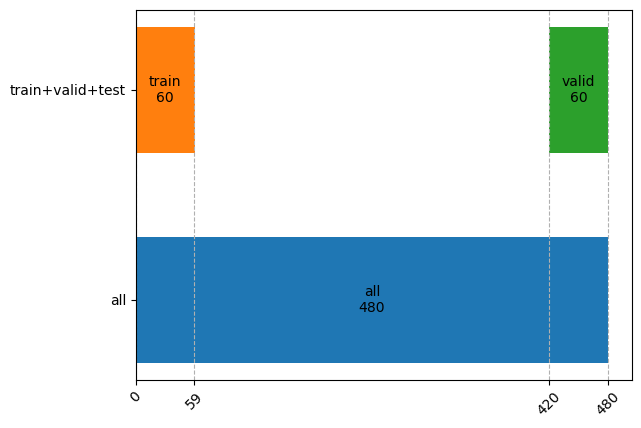

train_X.shape: (3300, 2200), train_y.shape: (3300, 100)
valid_X.shape: (3300, 2200), valid_y.shape: (3300, 100)
Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1, 100]                  --
├─Sequential: 1-1                        [1, 10, 2200]             --
│    └─Conv1d: 2-1                       [1, 10, 2200]             40
│    └─BatchNorm1d: 2-2                  [1, 10, 2200]             20
│    └─LeakyReLU: 2-3                    [1, 10, 2200]             --
├─ModuleList: 1-2                        --                        --
│    └─Sequential: 2-4                   [1, 1]                    --
│    │    └─Linear: 3-1                  [1, 1]                    22,001
│    └─Sequential: 2-5                   [1, 1]                    --
│    │    └─Linear: 3-2                  [1, 1]                    22,001
│    └─Sequential: 2-6                   [1, 1]                    --
│    │    └─Linear: 3-3            

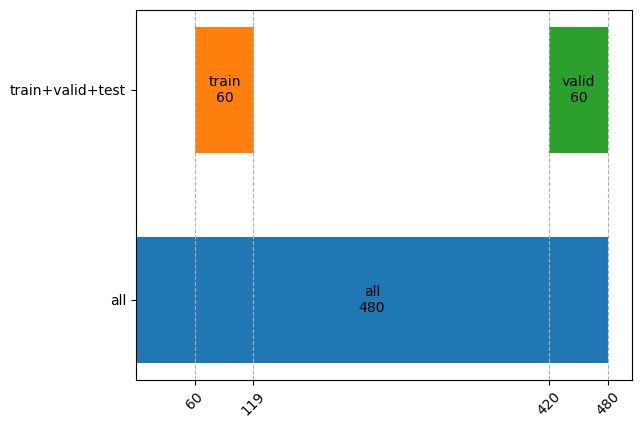

train_X.shape: (3300, 2200), train_y.shape: (3300, 100)
valid_X.shape: (3300, 2200), valid_y.shape: (3300, 100)
-------------------------------------------
epoch: 1/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.6253
      | mae = 6.6228
-------------------------------------------
valid | loss = 6.0856
      | mae = 6.0894
-------------------------------------------
-------------------------------------------
epoch: 2/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.4380
      | mae = 6.4378
-------------------------------------------
valid | loss = 6.1090
      | mae = 6.1130
-------------------------------------------
-------------------------------------------
epoch: 3/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.2562
      | mae = 6.2568
-------------------------------------------
valid | loss = 6.1230
      | mae = 6.1268
-----------------------------------------

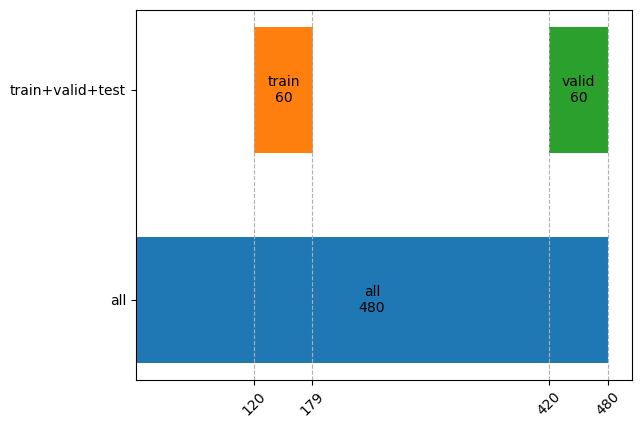

train_X.shape: (3300, 2200), train_y.shape: (3300, 100)
valid_X.shape: (3300, 2200), valid_y.shape: (3300, 100)
-------------------------------------------
epoch: 1/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 7.1700
      | mae = 7.1700
-------------------------------------------
valid | loss = 6.0772
      | mae = 6.0812
-------------------------------------------
-------------------------------------------
epoch: 2/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.9918
      | mae = 6.9902
-------------------------------------------
valid | loss = 6.1064
      | mae = 6.1104
-------------------------------------------
-------------------------------------------
epoch: 3/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.8217
      | mae = 6.8239
-------------------------------------------
valid | loss = 6.1233
      | mae = 6.1271
-----------------------------------------

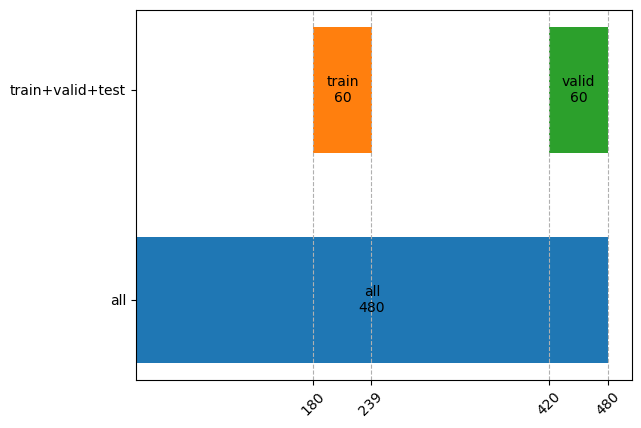

train_X.shape: (3300, 2200), train_y.shape: (3300, 100)
valid_X.shape: (3300, 2200), valid_y.shape: (3300, 100)
-------------------------------------------
epoch: 1/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 7.0791
      | mae = 7.0779
-------------------------------------------
valid | loss = 6.0826
      | mae = 6.0866
-------------------------------------------
-------------------------------------------
epoch: 2/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.8834
      | mae = 6.8860
-------------------------------------------
valid | loss = 6.1085
      | mae = 6.1127
-------------------------------------------
-------------------------------------------
epoch: 3/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.7096
      | mae = 6.7089
-------------------------------------------
valid | loss = 6.1396
      | mae = 6.1438
-----------------------------------------

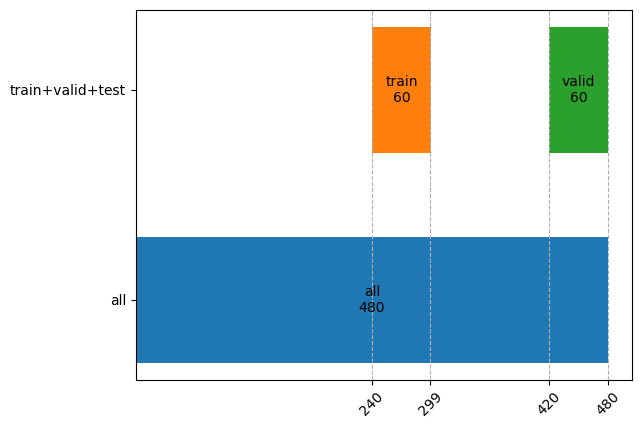

train_X.shape: (3300, 2200), train_y.shape: (3300, 100)
valid_X.shape: (3300, 2200), valid_y.shape: (3300, 100)
-------------------------------------------
epoch: 1/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 5.9989
      | mae = 5.9972
-------------------------------------------
valid | loss = 6.0779
      | mae = 6.0819
-------------------------------------------
-------------------------------------------
epoch: 2/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 5.7945
      | mae = 5.7950
-------------------------------------------
valid | loss = 6.0960
      | mae = 6.1000
-------------------------------------------
-------------------------------------------
epoch: 3/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 5.6179
      | mae = 5.6187
-------------------------------------------
valid | loss = 6.1267
      | mae = 6.1309
-----------------------------------------

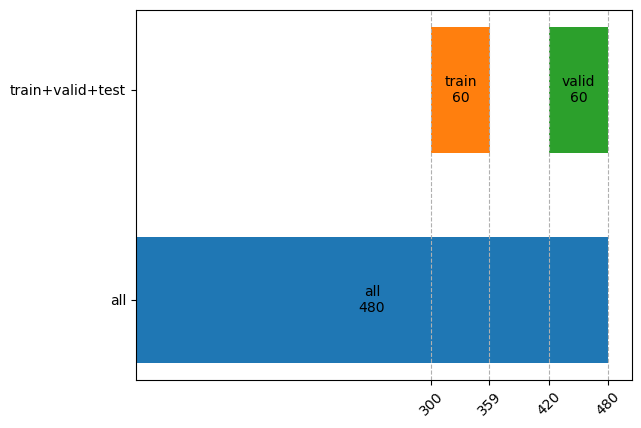

train_X.shape: (3300, 2200), train_y.shape: (3300, 100)
valid_X.shape: (3300, 2200), valid_y.shape: (3300, 100)
-------------------------------------------
epoch: 1/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.4787
      | mae = 6.4782
-------------------------------------------
valid | loss = 6.0733
      | mae = 6.0775
-------------------------------------------
-------------------------------------------
epoch: 2/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.2594
      | mae = 6.2608
-------------------------------------------
valid | loss = 6.1007
      | mae = 6.1047
-------------------------------------------
-------------------------------------------
epoch: 3/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.0701
      | mae = 6.0689
-------------------------------------------
valid | loss = 6.1277
      | mae = 6.1319
-----------------------------------------

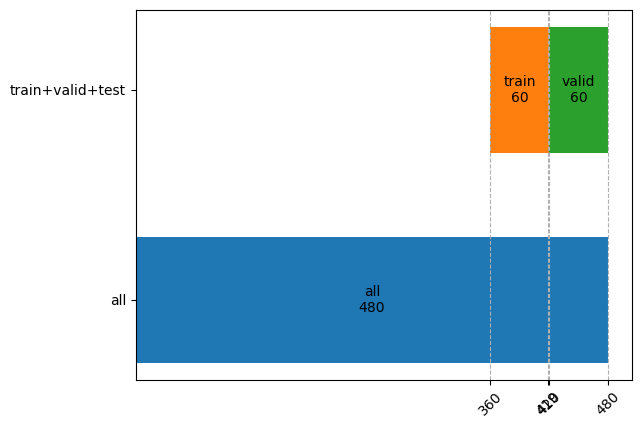

train_X.shape: (3300, 2200), train_y.shape: (3300, 100)
valid_X.shape: (3300, 2200), valid_y.shape: (3300, 100)
-------------------------------------------
epoch: 1/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.6142
      | mae = 6.6126
-------------------------------------------
valid | loss = 6.0756
      | mae = 6.0796
-------------------------------------------
-------------------------------------------
epoch: 2/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.4030
      | mae = 6.4023
-------------------------------------------
valid | loss = 6.1005
      | mae = 6.1043
-------------------------------------------
-------------------------------------------
epoch: 3/5
current lr = 1.0000e-03
-------------------------------------------
train | loss = 6.2131
      | mae = 6.2121
-------------------------------------------
valid | loss = 6.1204
      | mae = 6.1242
-----------------------------------------

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

stock_weights = torch.Tensor([
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
])
stock_weights = stock_weights[np.newaxis, :]

history, oof_true, oof_pred = train(
    dataset=train_df,
    outputs_dir=outputs_dir_path,
    device=device,
    weights=stock_weights,
)

In [11]:
print(f'oof true shape: {oof_true.shape}')
print(f'oof pred shape: {oof_pred.shape}')

oof true shape: (23100, 100)
oof pred shape: (23100, 100)


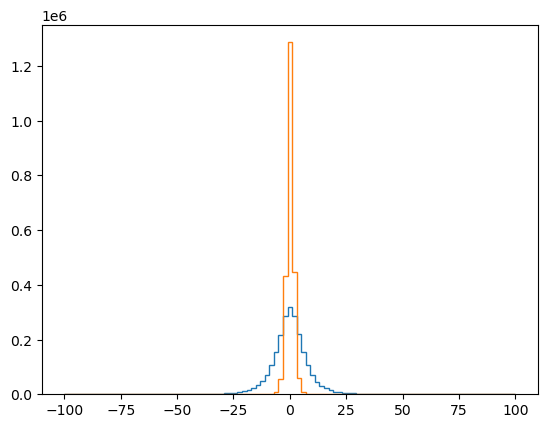

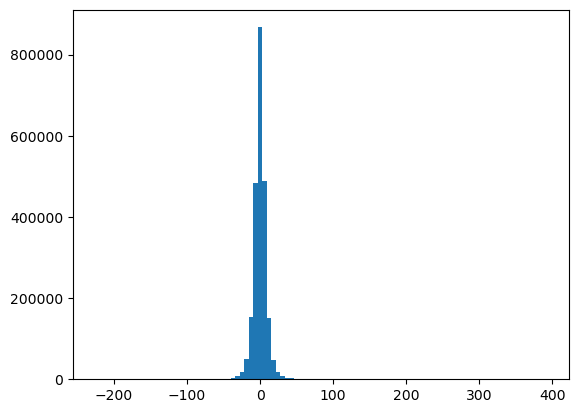

In [12]:
bins = np.linspace(-100, 100, 100)

_, ax = plt.subplots()
ax.hist(oof_true.flatten(), bins=bins, histtype='step')
ax.hist(oof_pred.flatten(), bins=bins, histtype='step')
plt.show()

_, ax = plt.subplots()
ax.hist(oof_true.flatten()-oof_pred.flatten(), bins=100)
plt.show()

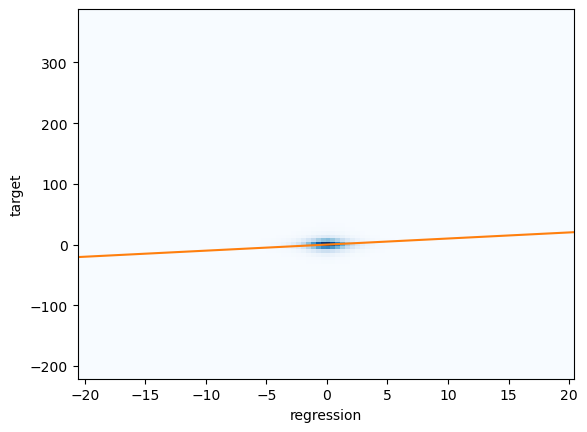

correlation coeeficient: 0.0095


In [13]:
_, ax = plt.subplots()
ax.hist2d(oof_pred.flatten(), oof_true.flatten(), bins=100, cmap='Blues')
ax.plot([-100, 100], [-100, 100], color='tab:orange')
ax.set_xlabel('regression')
ax.set_ylabel('target')
plt.show()

r = np.corrcoef(oof_pred.flatten(), oof_true.flatten())
print(f'correlation coeeficient: {r[0, 1]:.4f}')